In [22]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from isotope_data_module import isotopes


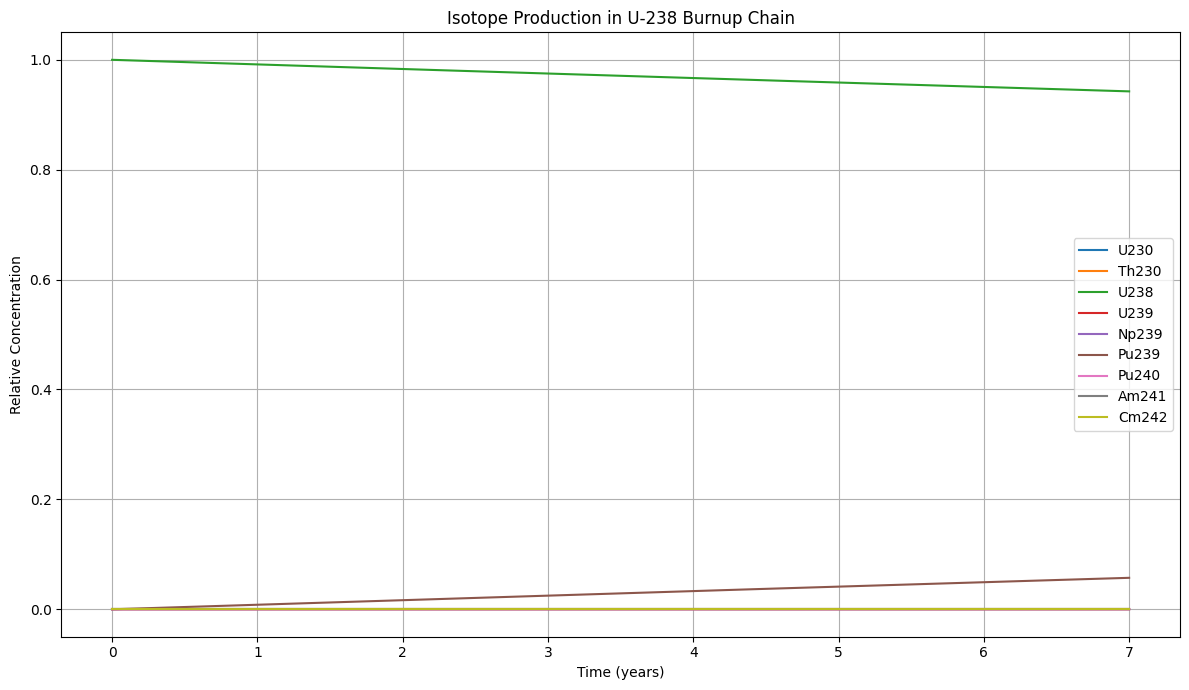

U230: 0.0000e+00
Th230: 0.0000e+00
U238: 9.4254e-01
U239: 5.1384e-07
Np239: 7.4204e-05
Pu239: 5.7205e-02
Pu240: 1.7500e-04
Am241: 1.3919e-07
Cm242: 4.4490e-11


In [24]:
phi = 1e14  # neutron flux [n/cm^2/s]
isotope_list = list(isotopes.keys())

# Map isotope to index for the ODE system
index_map = {iso: i for i, iso in enumerate(isotope_list)}
# Define the system of ODEs
def odes(t, y):
    dydt = np.zeros_like(y)
    for iso, props in isotopes.items():
        i = index_map[iso]
        loss = (props['n_gamma'] * phi + props['decay']) * y[i]
        prod = 0.0
        for parent, reaction in props['prod']:
            j = index_map[parent]
            if reaction == 'n_gamma':
                prod += isotopes[parent]['n_gamma'] * phi * y[j]
            elif reaction == 'decay':
                prod += isotopes[parent]['decay'] * y[j]
        dydt[i] = prod - loss
    return dydt

# Initial conditions (only U-238 present initially)
N0 = np.zeros(len(isotope_list))
# Ask user for starting isotope
start_isotope = input("Enter starting isotope (e.g., U238): ").strip()
if start_isotope not in index_map:
    raise ValueError(f"Isotope '{start_isotope}' not found in data.")

# Initial conditions
N0[index_map[start_isotope]] = 1.0

# Ask user how many years to simulate
years = float(input("Enter burnup duration in years (e.g., 10): "))
T_end = years * 365.25 * 24 * 3600  # convert years to seconds
t_eval = np.linspace(0, T_end, 1000)


# Solve the system
sol = solve_ivp(odes, [0, T_end], N0, t_eval=t_eval, method='BDF')

# Plot the results
plt.figure(figsize=(12, 7))
for i, iso in enumerate(isotope_list):
    plt.plot(sol.t / (365.25 * 24 * 3600), sol.y[i], label=iso)

plt.xlabel('Time (years)')
plt.ylabel('Relative Concentration')
plt.title('Isotope Production in U-238 Burnup Chain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the final concentrations
for i, iso in enumerate(isotope_list):
    print(f"{iso}: {sol.y[i][-1]:.4e}")
